Ablation
> "An ablation study typically refers to removing some "feature" of the model of algorithm, and seeing how that affects performance".  

모델이나 알고리즘의 “feature”들을 제거해 나가면서 그 행위가 성능에 얼마나 영향을 미치는지를 확인해보는 것을 의미

In [ ]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅시다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
BATCH_SIZE = 64
EPOCH = 25

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.


(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True, # 라벨값 불러오기
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
ds_info.features["label"].num_classes

2

In [ ]:
ds_info.features["label"].names

['cat', 'dog']

In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [ ]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
K = 2
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')

def conv1_layer(x):
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7,7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    return x

In [ ]:
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(64, (1, 1), strides=(1, 1), padding='same')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)        
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x

In [ ]:
def conv3_layer(x):
    shortcut = x

    for i in range(4): # 반복 수정
        if (i == 0):
            x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x) # 스트라이드 2로 수정, 필터 사이즈 수정
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
            shortcut = Conv2D(128, (1,1), strides=(2,2), padding='same')(shortcut) # 스트라이드 2로 수정
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x

In [ ]:
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        

            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(256, (1, 1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
  
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x

In [ ]:
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
 
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            shortcut = Conv2D(512, (1,1), strides=(2, 2), padding='same')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x

In [ ]:
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation='softmax')(x)
 
resnet34 = Model(input_tensor, output_tensor)
resnet34.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 230, 230, 3)  0          ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv2d_172 (Conv2D)            (None, 112, 112, 64  9472        ['zero_padding2d_8[0][0]']       
                                )                                                           

In [ ]:
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
resnet34_history = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
290/290 [==============================] - 86s 235ms/step - loss: 0.6688 - accuracy: 0.6167 - val_loss: 1.9624 - val_accuracy: 0.4967
Epoch 2/25
290/290 [==============================] - 67s 233ms/step - loss: 0.5884 - accuracy: 0.6858 - val_loss: 1.1126 - val_accuracy: 0.5458
Epoch 3/25
290/290 [==============================] - 68s 234ms/step - loss: 0.5411 - accuracy: 0.7234 - val_loss: 0.6387 - val_accuracy: 0.6469
Epoch 4/25
290/290 [==============================] - 68s 233ms/step - loss: 0.5016 - accuracy: 0.7514 - val_loss: 0.6856 - val_accuracy: 0.6213
Epoch 5/25
290/290 [==============================] - 68s 233ms/step - loss: 0.4521 - accuracy: 0.7863 - val_loss: 0.6011 - val_accuracy: 0.7025
Epoch 6/25
290/290 [==============================] - 68s 233ms/step - loss: 0.4043 - accuracy: 0.8168 - val_loss: 0.4850 - val_accuracy: 0.7574
Epoch 7/25
290/290 [==============================] - 67s 233ms/step - loss: 0.3546 - accuracy: 0.8445 - val_loss: 0.6061 - val_ac

In [ ]:
K = 2
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')

def conv1_layer(x):
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7,7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    return x

In [ ]:
def conv2_layer(x):
    x = MaxPooling2D((3,3), 2)(x)

    shortcut = x
    # resnet 50부터는 Bottleneck block 구조 사용
    for i in range(3):
        if (i == 0): 
            x = Conv2D(64, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1,1),strides=(1,1), padding='valid')(x)
            shortcut = Conv2D(256, (1,1), strides=(1,1), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(64, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x
    return x

In [ ]:
def conv3_layer(x):
    shortcut = x

    for i in range(4): # 반복 수정
        if (i == 0):
            x = Conv2D(128, (1,1), strides=(2,2), padding='valid')(x) # 스트라이드 2로 수정, 필터 사이즈 수정
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1,1),strides=(1,1), padding='valid')(x)
            shortcut = Conv2D(512, (1,1), strides=(2,2), padding='valid')(shortcut) # 스트라이드 2로 수정
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(128, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x

In [ ]:
def conv4_layer(x):
    shortcut = x

    for i in range(6): # 반복 수정
        if (i == 0):
            x = Conv2D(256, (1,1), strides=(2,2), padding='valid')(x) # 스트라이드 2로 수정
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1,1),strides=(1,1), padding='valid')(x) #st1이면 어짜피 valid
            shortcut = Conv2D(1024, (1,1), strides=(2,2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(256, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x

In [ ]:
def conv5_layer(x):
    shortcut = x

    for i in range(3):
        if (i==0):
            x = Conv2D(512, (1,1), strides=(2,2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1,1),strides=(1,1), padding='valid')(x)
            shortcut = Conv2D(2048, (1,1), strides=(2,2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(512, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3,3), strides=(1,1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1,1), strides=(1,1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x

In [ ]:
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)

x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)

resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input[0][0]']                  
 2D)                                                                                              
                                                                                                  
 conv2d_209 (Conv2D)            (None, 112, 112, 64  9472        ['zero_padding2d_10[0][0]']      
                                )                                                           

In [ ]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
resnet50_history = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
290/290 [==============================] - 126s 366ms/step - loss: 0.7085 - accuracy: 0.5656 - val_loss: 1.0823 - val_accuracy: 0.4905
Epoch 2/25
290/290 [==============================] - 105s 364ms/step - loss: 0.6706 - accuracy: 0.6112 - val_loss: 0.9940 - val_accuracy: 0.5135
Epoch 3/25
290/290 [==============================] - 105s 364ms/step - loss: 0.6535 - accuracy: 0.6270 - val_loss: 1.5755 - val_accuracy: 0.5092
Epoch 4/25
290/290 [==============================] - 106s 365ms/step - loss: 0.6563 - accuracy: 0.6256 - val_loss: 0.7045 - val_accuracy: 0.5948
Epoch 5/25
290/290 [==============================] - 106s 365ms/step - loss: 0.6376 - accuracy: 0.6467 - val_loss: 0.6677 - val_accuracy: 0.6211
Epoch 6/25
290/290 [==============================] - 106s 365ms/step - loss: 0.6297 - accuracy: 0.6505 - val_loss: 1.2934 - val_accuracy: 0.5347
Epoch 7/25
290/290 [==============================] - 106s 365ms/step - loss: 0.6217 - accuracy: 0.6594 - val_loss: 0.6521 -

In [ ]:
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   

def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     

    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x) 
            x = Activation('relu')(x)
            
 
        else:
            x = Conv2D(64, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)     
            x = Activation('relu')(x)    
    
    return x

 
def conv3_layer(x):    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)     
            x = Activation('relu')(x)     
        
        else:
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)       
            x = Activation('relu')(x)
            
    return x
 
 

def conv4_layer(x):  
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        

            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)          
        
        else:
            x = Conv2D(256, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
  
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)       
            x = Activation('relu')(x)    
 
    return x
 
 

def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
 
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)                
        
        else:
            x = Conv2D(512, (3,3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)                    
 
    return x
 
 
  
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation='softmax')(x)
 
plain_34 = Model(input_tensor, output_tensor)
plain_34.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_12 (ZeroPadd  (None, 230, 230, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_262 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_262 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_246 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 zero_padding2d_13 (ZeroPadd  (None, 114, 114, 64)     0   

In [ ]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
plain34_history = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
290/290 [==============================] - 82s 224ms/step - loss: 0.6908 - accuracy: 0.5587 - val_loss: 0.9614 - val_accuracy: 0.4907
Epoch 2/25
290/290 [==============================] - 65s 223ms/step - loss: 0.6882 - accuracy: 0.5567 - val_loss: 4.9327 - val_accuracy: 0.4935
Epoch 3/25
290/290 [==============================] - 65s 224ms/step - loss: 0.6811 - accuracy: 0.5725 - val_loss: 0.7119 - val_accuracy: 0.5312
Epoch 4/25
290/290 [==============================] - 65s 223ms/step - loss: 0.6619 - accuracy: 0.6078 - val_loss: 0.8592 - val_accuracy: 0.5697
Epoch 5/25
290/290 [==============================] - 65s 224ms/step - loss: 0.6521 - accuracy: 0.6174 - val_loss: 0.8328 - val_accuracy: 0.5517
Epoch 6/25
290/290 [==============================] - 65s 225ms/step - loss: 0.6338 - accuracy: 0.6415 - val_loss: 0.7166 - val_accuracy: 0.5812
Epoch 7/25
290/290 [==============================] - 65s 224ms/step - loss: 0.6399 - accuracy: 0.6315 - val_loss: 0.6969 - val_ac

In [ ]:
input_tensor = Input(shape = (224, 224, 3), dtype = 'float32', name = 'input')

def conv1_layer(x):
    x = ZeroPadding2D(padding = (3, 3))(x)
    x = Conv2D(64, (7, 7), strides = (2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding = (1, 1))(x)

    return x

def conv2_layer(x):
    x = MaxPooling2D((3, 3), 2)(x)

    for i in range(3):
        # conv2는 첫 번째 블록의 첫 번째 레이어도 stride = 1이다
        if (i == 0):
            x = Conv2D(64, (1, 1), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        else:
            x = Conv2D(64, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



def conv3_layer(x):
    shortcut = x

    for i in range(4):
        # 첫 번째 블록
        # 의 첫 번째 레이어는 stride = 2이다
        if (i == 0):
            x = Conv2D(128, (1, 1), strides = (2, 2), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        #첫 번째 이외의 블록
        else:
            x = Conv2D(128, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



def conv4_layer(x):
    shortcut = x

    for i in range(6):
        if (i == 0):
            x = Conv2D(256, (1, 1), strides = (2, 2), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1, 1), strides = (1,1), padding = 'valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        else:
            x = Conv2D(256, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



def conv5_layer(x):
    shortcut = x

    for i in range(3):
        if (i == 0):
            x = Conv2D(512, (1, 1), strides = (2, 2), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

        else:
            x = Conv2D(512, (1, 1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides = (1, 1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1,1), strides = (1,1), padding = 'same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    return x



x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)

x = GlobalAveragePooling2D()(x)
output_tensor = Dense(2, activation = 'softmax')(x)

plain_50 = Model(input_tensor, output_tensor)
plain_50.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 230, 230, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_295 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_295 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_279 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 zero_padding2d_15 (ZeroPadd  (None, 114, 114, 64)     0   

In [ ]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
plain50_history = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
290/290 [==============================] - 110s 316ms/step - loss: 0.6976 - accuracy: 0.5511 - val_loss: 0.8398 - val_accuracy: 0.4871
Epoch 2/25
290/290 [==============================] - 91s 313ms/step - loss: 0.6954 - accuracy: 0.5492 - val_loss: 0.9451 - val_accuracy: 0.5252
Epoch 3/25
290/290 [==============================] - 91s 313ms/step - loss: 0.6937 - accuracy: 0.5582 - val_loss: 1.1260 - val_accuracy: 0.5092
Epoch 4/25
290/290 [==============================] - 91s 314ms/step - loss: 0.6915 - accuracy: 0.5600 - val_loss: 0.6986 - val_accuracy: 0.5222
Epoch 5/25
290/290 [==============================] - 91s 314ms/step - loss: 0.6977 - accuracy: 0.5394 - val_loss: 0.6984 - val_accuracy: 0.5254
Epoch 6/25
290/290 [==============================] - 91s 314ms/step - loss: 0.6920 - accuracy: 0.5543 - val_loss: 0.7302 - val_accuracy: 0.5198
Epoch 7/25
290/290 [==============================] - 91s 314ms/step - loss: 0.6908 - accuracy: 0.5549 - val_loss: 0.8056 - val_a

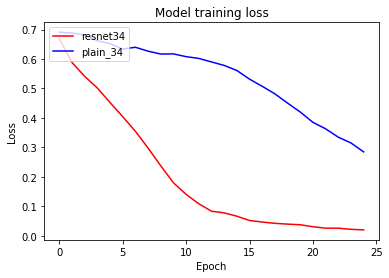

In [ ]:
import matplotlib.pyplot as plt

plt.plot(resnet34_history.history['loss'], 'r')
plt.plot(plain34_history.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_34'], loc='upper left')
plt.show()


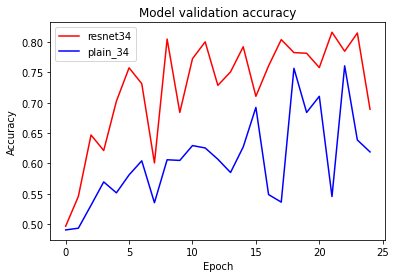

In [ ]:
plt.plot(resnet34_history.history['val_accuracy'], 'r')
plt.plot(plain34_history.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain_34'], loc='upper left')
plt.show()

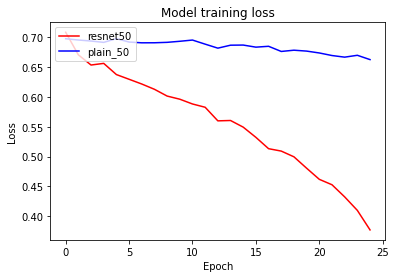

In [ ]:
plt.plot(resnet50_history.history['loss'], 'r')
plt.plot(plain50_history.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_50'], loc='upper left')
plt.show()

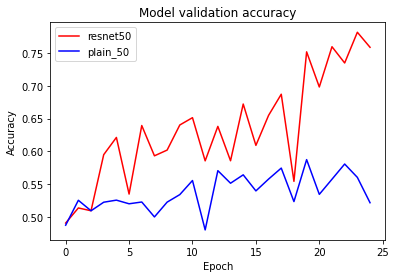

In [ ]:
plt.plot(resnet50_history.history['val_accuracy'], 'r')
plt.plot(plain50_history.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain_50'], loc='upper left')
plt.show()

# 간단 정리
* 네트워크를 깊게 쌓으면 발생하는 문제로 가장 확연히 들어나는 두가지가 바로 overfitting 문제와 degradation 문제 이 논문에서는 degradation 문제이다. (gradient vanishing/exploding문제)

* resnet은 skip connection을 이용한 residual learning을 통해
layer가 깊어짐에 따른 gradient vanishing 문제를 해결한다.

(아래의 이미지로 깊은 레이어가 training, test에서 높게나오는 것을 확인)

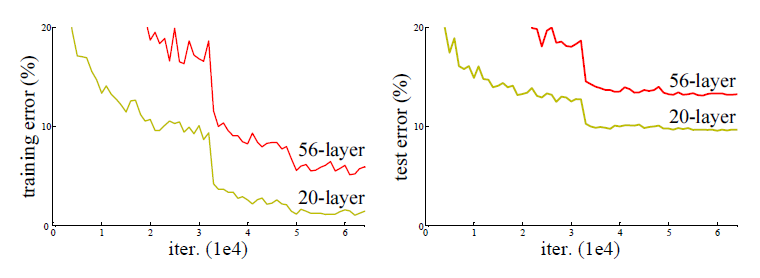

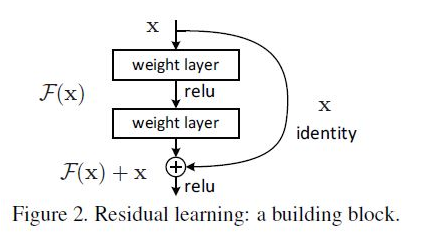

Residual: 수학적 의미로 예측된 값과 간측된 값의 차이
1. 이미지에서는 H(x) = x가 되도록 학습시킨다.

2. 네트워크의 output F(x)는 0이 되도록 학습시킨다.

3. F(x)+x=H(x)=x가 되도록 학습시키면 미분해도 F(x)+x의 미분값은 F'(x) + 1로 최소 1이상이다.

4. 모든 layer에서의 gradient가 1+F'(x)이므로 gradient vanishing현상을 해결했다.

정리하자면 누적된 영향으로 Back-propagation을 통해  Vanishing가 발생하는데, x(identity)를 더 해줌으로써 미분시 1의 값이 더해져 Vanishing를 방지 




# 회고

* 논문이라 그런가 이해하는게 너무 힘이 들었다. 특히나 Residual 부분이 너무 이해가 가지 않았다. 그리고 갑작스러운 코드 구현 또한 재미는 있었지만 여러 가지로 힘이 들었다. 아직까지도 논문의 이해와 코드의 이해가 부족한 거 같으며, 구현하기 위해 여러 문서를 참고하면서 코드를 이해하는 것도 조금 부족한 것을 느꼈다.
* 추가로 오버 피팅의 문제나 파라미터들의 수정, 시각화 등 다른 것들을 추가로 해보고 싶은 생각이 들었지만, 논문의 조금의 이해와 구현을 따라 해보는 걸로 만족하기로 했다.

